In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import torch
import albumentations as A
import matplotlib
import matplotlib.pyplot as plt
import torchvision

from PIL import Image
from sklearn.model_selection import StratifiedKFold
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running in {device} !!!')

Running in cuda !!!


In [3]:
bbox_df = pd.read_csv('data\\bbox_df.csv')
bbox_df

,path,label,xmin,ymin,xmax,ymax,num_label
0,Ally\left\left_0.png,ally_robot,280,51,749,606,1
1,Ally\left\left_0.png,ally_armor,445,427,584,504,2
2,Ally\left\left_1.png,ally_armor,513,448,632,519,2
3,Ally\left\left_1.png,ally_robot,302,55,914,668,1
4,Ally\left\left_10.png,ally_robot,571,156,958,527,1
...,...,...,...,...,...,...,...
470,Enemy\right\right_7.png,enemy_armor,264,393,334,441,4
471,Enemy\right\right_8.png,enemy_robot,583,170,921,524,3
472,Enemy\right\right_8.png,enemy_armor,671,385,739,432,4
473,Enemy\right\right_9.png,enemy_robot,563,145,961,514,3


In [4]:
data = Image.open('data\\Ally\\left\\left_0.png')
data = np.array(data)
data.shape

(720, 1280, 3)

In [5]:
transform = {
    'train': A.Compose([A.CenterCrop(height=650, width=1110, p=0.5),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Rotate(limit=45, p=0.3),
                        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.5),
                        A.Resize(height=720, width=1280, p=1.0),
                        A.Cutout(num_holes=15, max_h_size=50, max_w_size=50, p=0.5),
                        ToTensorV2(p=1.0)], p=1.0, bbox_params={'format': 'pascal_voc',
                                                        'label_fields': ['labels'],
                                                        'min_area': 0,
                                                        'min_visibility': 0}),

    'valid': A.Compose([A.Resize(height=720, width=1280, p=1.0),
                        ToTensorV2(p=1.0)], p=1.0, bbox_params={'format': 'pascal_voc',
                                                               'label_fields': ['labels'],
                                                               'min_area': 0,
                                                               'min_visibility': 0,}),
    
    'test': A.Compose([A.Resize(height=720, width=1280, p=1.0),
                       ToTensorV2(p=1.0)], p=1.0),
                        
}

In [6]:
'''
boxes
image_id
labels
area
iscrowd
'''

class CarDataset(Dataset):
    def __init__(self, root, df, transform=None):
        self.root = root
        self.df = df
        self.transform = transform
        self.image_paths = df['path'].unique()
    
    def __getitem__(self, index):
        name = self.image_paths[index]
        image_path = os.path.join(self.root, name)
        image = Image.open(image_path).convert('RGB')
        image= np.array(image).astype(np.float32) / 255.0
        
        boxes = self.df[self.df['path'] == name][['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = torch.tensor(boxes)
        image_id = torch.tensor([index])
        labels = torch.tensor(self.df[self.df['path'] == name]['num_label'].values, dtype=torch.int64)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.tensor((boxes.shape[0], ), dtype=torch.int64)
    
        target = {}
        target['boxes'] = boxes
        target['image_id'] = image_id
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transform is not None:
            tsfm = self.transform(**{
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            })
            for i in range(10):
                if len(tsfm['bboxes']) > 0:
                    image = tsfm['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, [box for box in tsfm['bboxes']])))
                    break
                    
        return image, target
        
    def __len__(self):
        return len(self.image_paths)

In [7]:
root = 'data'
ds = CarDataset(root=root, df=bbox_df, transform=transform['train'])

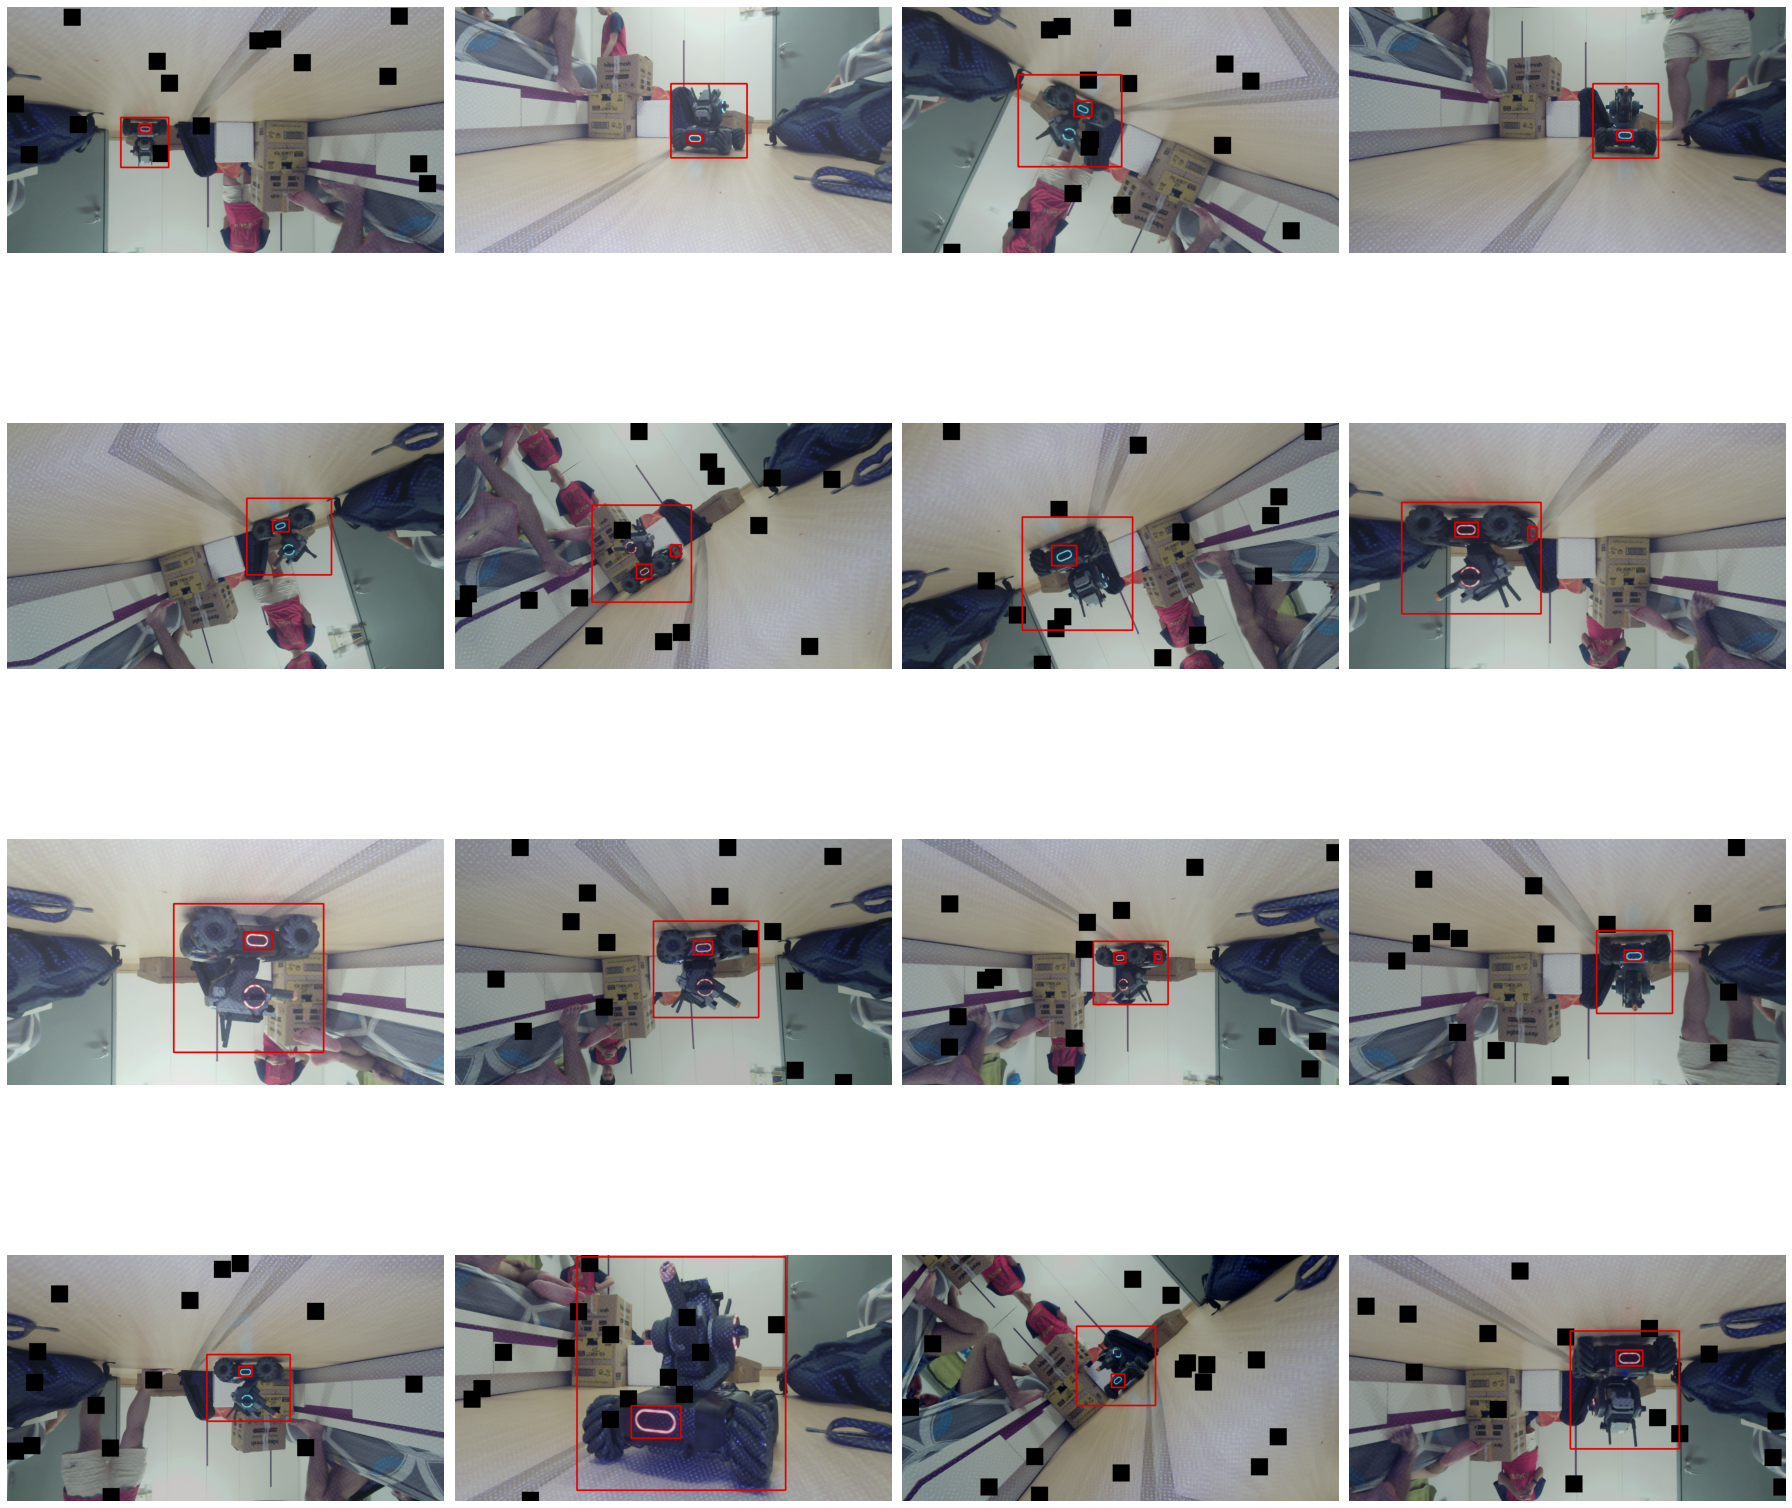

In [8]:
matplotlib.rcParams['figure.figsize'] = (25, 25)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image, target = ds[torch.randint(0, len(ds), (1,)).item()]
    np_image = image.mul(255).byte().permute(1,2,0).cpu().numpy()
    boxes = target['boxes'].cpu().numpy().astype(np.int32)
    
    for box in boxes:
        cv2.rectangle(np_image, (box[0], box[1]), (box[2], box[3]), (225, 0, 0), 3)
    plt.imshow(np_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
class Averager():
    def __init__(self):
        self.current_train_total = 0.0
        self.train_iteration = 0.0
        self.current_valid_total = 0.0
        self.valid_iteration =0.0
        
    def send_train(self, value):
        self.current_train_total += value
        self.train_iteration += 1
    
    def send_valid(self, value):
        self.current_valid_total += value
        self.valid_iteration += 1
    
    @property
    def train_value(self):
        if self.train_iteration == 0:
            return 0
        else:
            return 1.0 * self.current_train_total / self.train_iteration
    
    @property
    def valid_value(self):
        if self.valid_iteration == 0:
            return 0
        else:
            return 1.0 * self.current_valid_total / self.valid_iteration
        
    def reset(self):
        self.current_train_total = 0.0
        self.train_iteration = 0.0
        self.current_valid_total = 0.0
        self.valid_iteration = 0.0
        
def get_model(num_classes, checkpoint=None):
    pretrained = False if checkpoint is not None else True
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained, pretrained_backbone=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if checkpoint is not None:
        model.load_state_dict(torch.load(checkpoint))
    return model.to(device)

In [10]:
def learn(epochs, model, lr, train_dl, valid_dl, ave, weight_decay=0, opt_fc=torch.optim.Adam):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = opt_fc(params=params, lr=lr, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=1, threshold_mode='abs')
    loss_history = ave()
    history = []
    best_model_loss = 0
    
    for epoch in range(1, epochs + 1):
        itr = 0
        result = {}
        loss_history.reset()
        
        model.train()        
        for images, targets in train_dl:
            images = list(image.to(device) for image in images)
            targets = [{key: value.to(device) for key, value in target.items()} for target in targets]
            
            loss_dict = model(images, targets)
            
            losses = sum(loss for loss in loss_dict.values())
            
            loss_value = losses.item()
            loss_history.send_train(loss_value)
            torch.nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            if not itr % round(len(train_dl)/3):
                print('Iteration [{}/{}], train_loss: {:.4f}'.format(itr, len(train_dl) - 1, loss_history.train_value))
            itr += 1
        
        evaluate(model=model, dl=valid_dl, ave=loss_history)
        
        result['lr'] = optimizer.param_groups[0]['lr']
        result['train_loss'] = loss_history.train_value
        result['valid_loss'] = loss_history.valid_value
        
        if (result['valid_loss'] < best_model_loss) or (epoch == 1):
            best_model_loss = result['valid_loss']
            torch.save(model.state_dict(), f'weight\\fold{fold}_resnet50_BestModel.pth')
            print('Best Model Saved!')
            
        lr_scheduler.step(result['valid_loss'])
        
        print('Epoch [{}/{}], last_lr: {:.8f}, train_loss: {:.4f}, val_loss: {:.4f}\n'.format(epoch, 
                                                                                              epochs, 
                                                                                              result['lr'], 
                                                                                              result['train_loss'], 
                                                                                              result['valid_loss']))
        history.append(result)
    return history

@torch.no_grad()
def evaluate(model, dl, ave):
    for images, targets in dl:
        images = list(image.to(device) for image in images)
        targets = [{key: value.to(device) for key, value in target.items()} for target in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        ave.send_valid(loss_value)

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

bbox_df.loc[:, 'fold'] = 0
n_fold = 6
batch_size = 1

skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
histories = []

for fold, (train_indices, valid_indices) in enumerate(skf.split(X=bbox_df.index, y=bbox_df['num_label'])):
    bbox_df.loc[valid_indices, 'fold'] = fold

    
for fold in range(n_fold):
    train_df = bbox_df[bbox_df['fold'] != fold].reset_index(drop=True)
    valid_df = bbox_df[bbox_df['fold'] == fold].reset_index(drop=True)

    train_ds = CarDataset(root=root, df=train_df, transform=transform['train'])
    valid_ds = CarDataset(root=root, df=valid_df, transform=transform['valid'])

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size * 8, shuffle=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

    num_classes = 5
    epochs = 20
    lr = 1e-5
    weight_decay = 1e-7
    checkpoint = None

    model = get_model(num_classes, checkpoint=checkpoint)

    history = []
    history += learn(epochs, model, lr, train_dl, valid_dl, ave=Averager, weight_decay=weight_decay)
    
    learn_res_df = pd.DataFrame(history)
    learn_res_df.to_csv(f'learning_logs\\fold{fold}_LearnResult.csv')

    histories.append(history)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Iteration [0/196], train_loss: 2.0229
Iteration [66/196], train_loss: 0.6564
Iteration [132/196], train_loss: 0.5534
Best Model Saved!
Epoch [1/20], last_lr: 0.00001000, train_loss: 0.4927, val_loss: 0.2368

Iteration [0/196], train_loss: 0.5410
Iteration [66/196], train_loss: 0.3326
Iteration [132/196], train_loss: 0.3255
Best Model Saved!
Epoch [2/20], last_lr: 0.00001000, train_loss: 0.2980, val_loss: 0.1763

Iteration [0/196], train_loss: 0.1437
Iteration [66/196], train_loss: 0.2253
Iteration [132/196], train_loss: 0.2307
Best Model Saved!
Epoch [3/20], last_lr: 0.00001000, train_loss: 0.2262, val_loss: 0.1382

Iteration [0/196], train_loss: 0.1110
Iteration [66/196], train_loss: 0.1947
Iteration [132/196], train_loss: 0.1933
Epoch [4/20], last_lr: 0.00001000, train_loss: 0.1985, val_loss: 0.1469

Iteration [0/196], train_loss: 0.1609
Iteration [66/196], train_loss: 0.1816
Iteration [132/196], train_loss: 0.1915
Epoch [5/20], last_lr: 0.00001000, train_loss: 0.1870, val_loss: 0.15

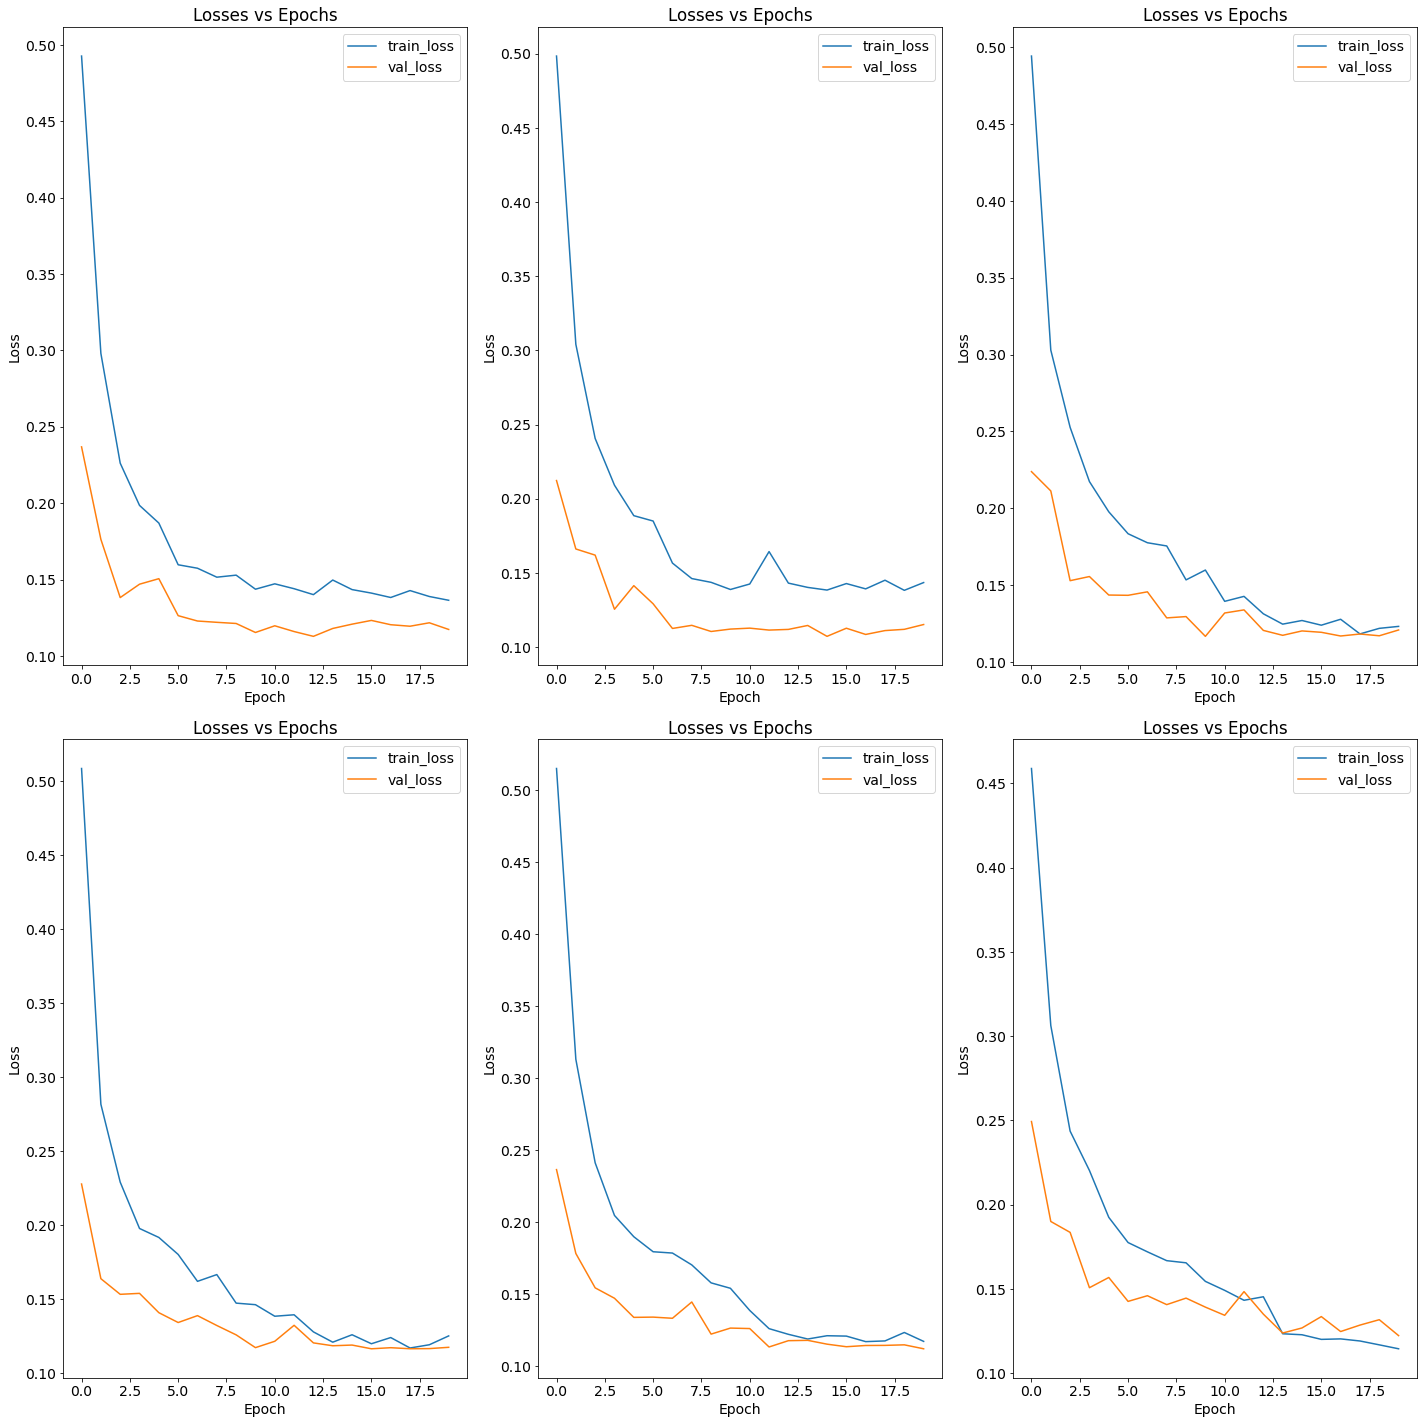

In [12]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20,20)

for i, history in enumerate(histories):
    train_losses = [x.get('train_loss') for x in history]
    valid_losses = [x.get('valid_loss') for x in history]

    plt.subplot(2, 3, i + 1)
    plt.plot(train_losses)
    plt.plot(valid_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.title('Losses vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

plt.tight_layout()
plt.show()